In [64]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

In [33]:
df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/train_FD001.txt', index_col=0, sep=" ", header=None)
column_indices = np.arange(df.shape[1]-1).tolist()

index_columns_names =  ["cycle"]
op_settings_columns = ["op_setting_"+str(i) for i in range(1,4)]
sensor_columns =["sensor_"+str(i) for i in range(1,22)]
new_names = index_columns_names + op_settings_columns + sensor_columns

old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.index.names = ['engine']
df.drop([26, 27], axis=1, inplace=True)
df_sensor_14 = df[['cycle', 'sensor_14']]
df_sensor_14 = df_sensor_14.reset_index()

,engine,cycle,sensor_14
0,1,1,8138.62
1,1,2,8131.49
2,1,3,8133.23
3,1,4,8133.83
4,1,5,8133.80
...,...,...,...
20626,100,196,8137.60
20627,100,197,8136.50
20628,100,198,8141.05
20629,100,199,8139.29


In [39]:
pivot_df = df_sensor_14.pivot(index='cycle', columns='engine', values='sensor_14')

# pivot_df = pivot_df.dropna() # truncate, only deal with the first 128 timestamps -- starting from 129th timestamp failure occured for one trajectory
pivot_df.index.name = 'timestamps'
pivot_df.index = pd.to_datetime(pivot_df.index, origin='1970-01-01', unit='D')
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
timestamps,,,,,,,,,,,,,,,,,,,,,
1970-01-02,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-03,8131.49,8131.09,8137.38,8129.53,8153.04,8126.01,8148.24,8120.18,8148.23,8142.57,...,8131.08,8135.54,8141.41,8126.19,8151.85,8136.21,8131.43,8147.03,8132.70,8143.56
1970-01-04,8133.23,8140.58,8137.20,8131.24,8148.42,8125.49,8148.83,8122.29,8140.94,8136.85,...,8134.12,8137.39,8140.79,8130.38,8148.79,8134.72,8129.52,8149.19,8132.44,8146.62
1970-01-05,8133.83,8140.44,8139.35,8132.90,8148.81,8117.06,8150.30,8123.80,8145.41,8136.62,...,8127.29,8135.96,8144.72,8126.63,8148.08,8134.52,8131.14,8156.01,8133.19,8146.60
1970-01-06,8133.80,8136.67,8135.99,8126.94,8147.69,8124.10,8149.40,8118.15,8145.92,8138.95,...,8132.13,8138.76,8144.23,8129.45,8144.88,8135.34,8130.03,8148.47,8132.30,8141.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
first_valid_values = pivot_df.apply(lambda col: col.dropna().iloc[0])
for i in range(1, pivot_df.shape[1] + 1):
    pivot_df[i] = pivot_df[i].shift(periods=pivot_df[i].isna().sum(), fill_value=np.nan)
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
timestamps,,,,,,,,,,,,,,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-12-25,8117.69,8174.85,8238.86,8246.77,8203.89,8110.10,8146.81,8120.84,8266.83,8173.14,...,8119.61,8194.88,8138.51,8210.36,8179.43,8142.08,8255.95,8130.96,8123.55,8137.60
1970-12-26,8117.51,8166.83,8251.82,8241.99,8208.49,8110.79,8139.94,8117.88,8271.39,8177.31,...,8120.68,8201.61,8133.67,8208.35,8189.10,8140.98,8258.58,8136.99,8130.99,8136.50
1970-12-27,8112.58,8164.83,8249.86,8253.53,8206.86,8108.26,8149.60,8126.20,8272.83,8181.11,...,8120.11,8202.93,8143.45,8212.30,8187.88,8145.65,8257.38,8133.76,8126.90,8141.05


<Axes: xlabel='timestamps'>

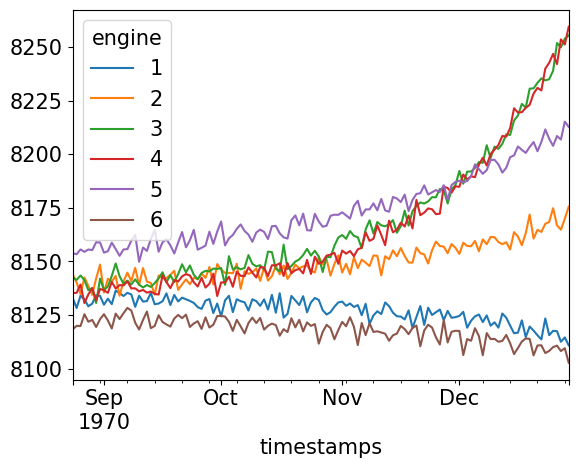

In [41]:
pivot_df = pivot_df.dropna() 
pivot_df[[1,2,3,4,5,6]].plot() 

In [60]:
from gluonts.dataset.split import split, DateSplitter

# Create a GluonTS dataset
dataset = PandasDataset(pivot_df, target="target")

# dataset = PandasDataset.from_long_dataframe(pivot_df, target="target", item_id='item_id')

# Split the dataset
split_date = pd.Period("1970-11-15", freq="D")
splitter = DateSplitter(split_date)
training_dataset, test_template = split(dataset, date=splitter)

# Generate test input/output pairs
prediction_length = 12
test_pairs = test_template.generate_instances(prediction_length, windows=1)

In [61]:
# convert df to training and testing datasets
# prediction_length = 24

# train_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values[:-prediction_length]} for i in pivot_df.columns] # (128 - 24) by 100
# test_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values} for i in pivot_df.columns] # 128 by 100

# train_ds = ListDataset(data_iter=train_data, freq='1H') # training dataset
# test_ds = ListDataset(data_iter=test_data, freq='1H') # testing dataset

train_ds = training_dataset
test_ds = test_pairs

In [62]:
prediction_length = 24 # default
num_samples = 100 # default - for probability forecasting, try 10->100 this time
context_length = 32
device = "mps"

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=10e-4, # training params

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        }, 

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [63]:
# training the predictor

predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


KeyError: 'target'

In [27]:
# inference on test datasets using the fine-tuned predictor

forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=num_samples)

forecasts = list(forecast_it)
tss = list(ts_it)

# inference time: 13min

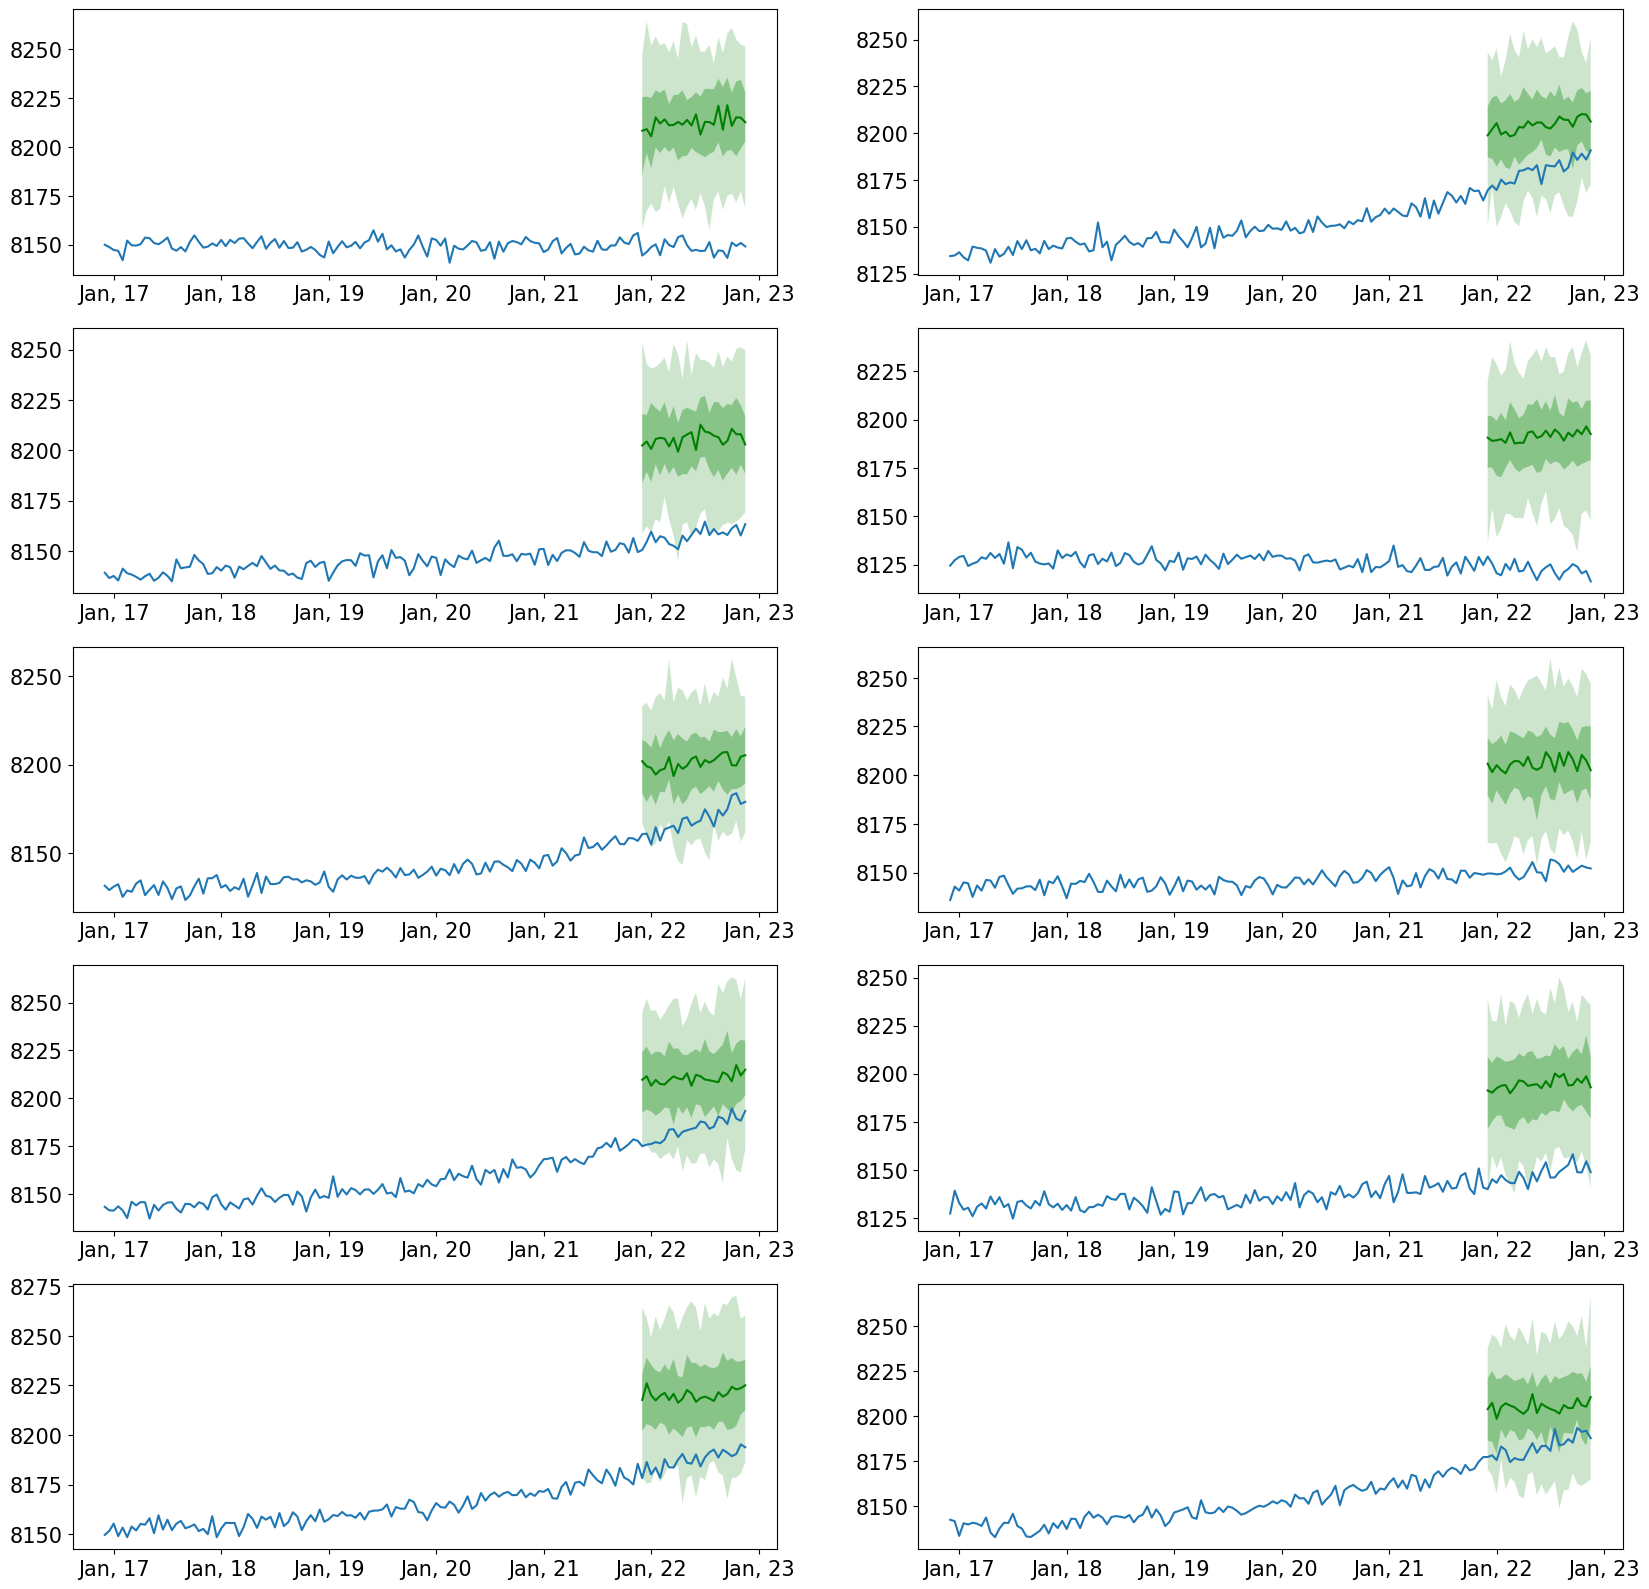

In [28]:
plt.figure(figsize=(20, 20))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples 
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 10):
    ax = plt.subplot(5, 2, idx+1)

    plt.plot(ts[-6 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks()
    ax.xaxis.set_major_formatter(date_formater)

In [14]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss']) 
# CRPS: 0.0031304983256903937 for aligning at the end and trimming the beginning
# CRPS: 0.003155105264314208 for aligning at the end and leaving NaN at the beginning
# CRPS: 0.00494559862857452 for sampling 100 times at inference time

Running evaluation: 100it [00:00, 1395.84it/s]
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up seria

CRPS: 0.00494559862857452
